<a href="https://colab.research.google.com/github/wei-enwang/space-ham/blob/main/main_driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import nltk
from nltk.corpus import words
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils import data
from preprocess import WholeData, BalancedData

import models
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/weinwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nltk.download('words')

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 32
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

[nltk_data] Downloading package words to /home/weinwang/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
plot_yes = True

# use one dataset for now
train_data_dir = "./data/enron1/"
test_data_dir = "./data/enron2/"
output_dir = "./output/"

# hyperparameters
batch_size = 64
hidden_size = 128
num_layer = 3
dropout = 0.5
learning_rate = 1e-4
epochs = 10
max_len = 50

In [4]:
vocab = set([str.lower() for str in words.words()])

# train_dataset = WholeData(train_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
# test_dataset = WholeData(test_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
# Balanced dataset
train_dataset = BalancedData(train_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
test_dataset = BalancedData(test_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)

w2idx = train_dataset.src_v2id

embed = utils.load_pretrained_vectors(w2idx, "fastText/crawl-300d-2M.vec")
embed = torch.tensor(embed)

Number of ham emails: 1500, spam emails: 1500
Number of ham emails: 1496, spam emails: 1496
Loading pretrained vectors...
234378


0it [00:00, ?it/s]

There are 75835 / 234379 pretrained vectors found.


In [5]:
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                   num_workers=8, pin_memory=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                  num_workers=8, pin_memory=True, drop_last=True)


In [6]:
model = models.spam_lstm(hidden_size=hidden_size, pretrained_embedding=embed, dropout=dropout).to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
opt = Adam(model.parameters(), lr=learning_rate)

Using pretrained vectors...


 10%|█         | 1/10 [00:03<00:32,  3.61s/it]

Epoch 0
-------------------------------
Training loss: 0.693152, avg accuracy: 0.500237
Testing loss: 0.692380, avg accuracy: 0.500000


 20%|██        | 2/10 [00:07<00:28,  3.61s/it]

Epoch 1
-------------------------------
Training loss: 0.689316, avg accuracy: 0.500142
Testing loss: 0.682506, avg accuracy: 0.500679


 30%|███       | 3/10 [00:10<00:25,  3.61s/it]

Epoch 2
-------------------------------
Training loss: 0.509741, avg accuracy: 0.660049
Testing loss: 0.389208, avg accuracy: 0.867527


 40%|████      | 4/10 [00:14<00:21,  3.60s/it]

Epoch 3
-------------------------------
Training loss: 0.194749, avg accuracy: 0.944766
Testing loss: 0.375509, avg accuracy: 0.861753


 50%|█████     | 5/10 [00:18<00:17,  3.60s/it]

Epoch 4
-------------------------------
Training loss: 0.139152, avg accuracy: 0.963858
Testing loss: 0.397842, avg accuracy: 0.867527


 60%|██████    | 6/10 [00:21<00:14,  3.59s/it]

Epoch 5
-------------------------------
Training loss: 0.124875, avg accuracy: 0.966423
Testing loss: 0.383876, avg accuracy: 0.874660


 70%|███████   | 7/10 [00:25<00:10,  3.58s/it]

Epoch 6
-------------------------------
Training loss: 0.103914, avg accuracy: 0.974972
Testing loss: 0.330794, avg accuracy: 0.895720


 80%|████████  | 8/10 [00:28<00:07,  3.59s/it]

Epoch 7
-------------------------------
Training loss: 0.100114, avg accuracy: 0.976064
Testing loss: 0.347972, avg accuracy: 0.895380


 90%|█████████ | 9/10 [00:32<00:03,  3.59s/it]

Epoch 8
-------------------------------
Training loss: 0.093136, avg accuracy: 0.977536
Testing loss: 0.359068, avg accuracy: 0.896060


100%|██████████| 10/10 [00:35<00:00,  3.59s/it]

Epoch 9
-------------------------------
Training loss: 0.086583, avg accuracy: 0.979056
Testing loss: 0.326670, avg accuracy: 0.904891


Final testing loss: 0.321700, testing accuracy: 0.905910
F1 score: 0.902841 Precision: 0.934641, Recall: 0.873134


(0.08658300950489145, 0.32169952535110974)

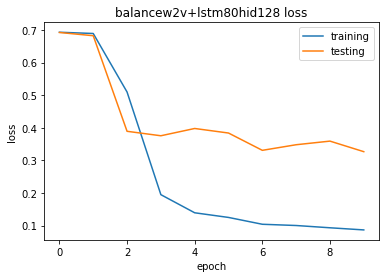

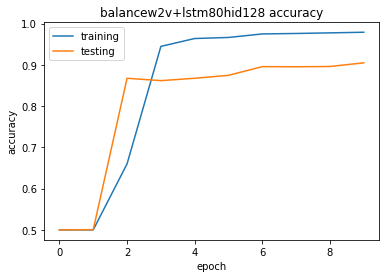

In [7]:
utils.train_test_scheme(train_dataloader, test_dataloader, model, loss_fn, opt, 
                        task_name="balancew2v+lstm80hid128", epochs=epochs, 
                        vis=plot_yes, print_every=1, img_dir=output_dir)



In [8]:
torch.save(model.state_dict(), output_dir+"balancew2v_lstm80hid128.pt")